In [1]:
import json, os
import cv2
import torch
from multiprocessing import Pool, Manager
from aquabyte.data_access_utils import S3AccessUtils, RDSAccessUtils
from aquabyte.akpd import AKPD
from aquabyte.template_matching import find_matches_and_homography
from aquabyte.biomass_estimator import NormalizeCentered2D, NormalizedStabilityTransform, ToTensor, Network
from aquabyte.data_loader import KeypointsDataset, NormalizeCentered2D, ToTensor, BODY_PARTS
from torch.utils.data import Dataset, DataLoader
from aquabyte.optics import euclidean_distance, pixel2world, depth_from_disp, convert_to_world_point

from aquabyte.akpd_scorer import generate_confidence_score
from keras.models import load_model
import boto3
import pandas as pd
import numpy as np
import plotly.express as px
import time
from matplotlib import pyplot as plt

from collections import defaultdict
import datetime as dt
import json
import numpy as np
from sklearn.linear_model import LinearRegression
from collections import defaultdict



Using TensorFlow backend.


In [2]:
from collections import defaultdict
import json
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression

# compute daily growth rate via fitting an exponential curve,
# weighting each day by its sample size
def compute_growth_rate(tdf, rdf, start_date, end_date):
    x_values = [(dt.datetime.strptime(k, '%Y-%m-%d') - \
                 dt.datetime.strptime(start_date, '%Y-%m-%d')).days \
                 for k in tdf.index.date.astype(str)]
    X = np.array(x_values).reshape(-1, 1)
    y = np.log(tdf.values)
    reg = LinearRegression().fit(X, y, sample_weight=rdf.values)
    growth_rate = reg.coef_[0]
    trend_score = reg.score(X, y, sample_weight=rdf.values)
    return growth_rate, trend_score


# compute distribution confidence via looking at RMS of percent deviations for qq plot
# of today's distribution against distribution in the remainder of the window
def compute_distribution_confidence(df, start_date, end_date, date):
    mean_adjustment = df[date:date].estimated_weight_g.mean() - df[start_date:end_date].estimated_weight_g.mean()
    x = np.percentile(df[start_date:end_date].estimated_weight_g + mean_adjustment, list(range(100)))
    y = np.percentile(df[date:date].estimated_weight_g, list(range(100)))
    distribution_confidence = np.mean(np.square((x[1:99] - y[1:99]) / y[1:99])) ** 0.5
    return distribution_confidence


# NOTE: we need to think more carefully about this to understand how distribution 
# confidence and trend score affect the minimum sample size we want. Hardcoded for now. 
def compute_minimum_sample_size(distribution_confidence, trend_score):
    return 5000
    
# Smart average is defined as a lookback to a maximum of window_size_d days (currently set to 7),
# or until the minimum sample size is achieved
def compute_smart_average(df, tdf, rdf, date, distribution_confidence, growth_rate, 
                          trend_score, window_size_d, bucket_size=0.1):
    
    dates = sorted(list(tdf.index.date.astype(str)))
    if len(dates) == 1:
        growth_rate = 0.0
    minimum_sample_size = compute_minimum_sample_size(distribution_confidence, trend_score)
    x_values = [(dt.datetime.strptime(date, '%Y-%m-%d') - \
                 dt.datetime.strptime(k, '%Y-%m-%d')).days \
                 for k in tdf.index.date.astype(str)]
    X = np.array(x_values).reshape(-1, 1)
    Y = tdf.values
    N = rdf.values
    
    for i in range(window_size_d):
        if N[np.abs(np.squeeze(X)) <= i].sum() >= minimum_sample_size:
            break
    N[np.abs(np.squeeze(X)) > i] = 0
    
    smart_average = 0.0
    sample_size = 0.0
    adj_weights = []
    total_days = 0
    for x, y, n, this_date in zip(X, Y, N, dates):
        smart_average += np.exp(x * growth_rate) * y * n
        sample_size += n
        if n > 0:
            adj_weights_for_date = \
                list(np.exp(x * growth_rate) * df[this_date:this_date].estimated_weight_g.values)
            adj_weights.extend(adj_weights_for_date)
            total_days += 1
        
    smart_average /= sample_size
    
    adj_weights = np.array(adj_weights)
    distribution = {}
    buckets = [round(x, 1) for x in np.arange(0.0, 1e-3 * adj_weights.max(), bucket_size)]
    for b in buckets:
        low, high = 1e3 * b, 1e3 * (b + bucket_size)
        count = adj_weights[(adj_weights >= low) & (adj_weights < high)].shape[0]
        distribution[b] = count / sample_size
    
    output = {
        'weightMovingAvg': float(smart_average),
        'weightMovingDist': distribution,
        'numMovingAvgBatiFish': sample_size,
        'numMovingAvgLookbackDays': total_days,
        'dailyGrowthRate': growth_rate
    }
    
    return output


# generate date range given current date and window size. If future data
# is available relative to current date, windows where the current date
# is centered are preferred
def compute_date_range(historical_dates, date, window_size_d):
    FMT = '%Y-%m-%d'
    max_num_days = 0
    start_date, end_date = None, None
    for i in range(window_size_d // 2 + 1):
        lower_bound_date = (dt.datetime.strptime(date, FMT) - dt.timedelta(days=window_size_d-1) + \
                            dt.timedelta(days=i)).strftime(FMT)
        upper_bound_date = (dt.datetime.strptime(date, FMT) + dt.timedelta(days=i)).strftime(FMT)
        num_days = ((np.array(historical_dates)  >= lower_bound_date) & \
                    (np.array(historical_dates) <= upper_bound_date)).sum()
        if num_days >= max_num_days:
            start_date, end_date = lower_bound_date, upper_bound_date
            max_num_days = num_days
    
    return start_date, end_date


def compute_metrics(date, records_json, window_size_d=7):
    
    records = json.loads(records_json)
    
    dts, vals = [], []
    for iter_date in records:
        for val in records[iter_date]:
            dts.append(iter_date)
            vals.append(val)

    df = pd.DataFrame(vals, index=pd.to_datetime(dts), columns=['estimated_weight_g'])
    
    # get raw statistics
    raw_avg_weight = df[date:date].estimated_weight_g.mean()
    raw_sample_size = df[date:date].shape[0]
    
    # compute relevant date range
    historical_dates = sorted(list(set(df.index.date.astype(str))))
    start_date, end_date = compute_date_range(historical_dates, date, window_size_d)
    rdf = df[start_date:end_date].estimated_weight_g.resample('D').agg(lambda x: x.shape[0])
    tdf = df[start_date:end_date].estimated_weight_g.resample('D').agg(lambda x: x.mean())
    tdf = tdf[rdf > 0].copy(deep=True)
    rdf = rdf[rdf > 0].copy(deep=True)
    
    growth_rate, trend_score, distribution_confidence = None, None, None
    if start_date < end_date:
        growth_rate, trend_score = compute_growth_rate(tdf, rdf, start_date, end_date)
        distribution_confidence = compute_distribution_confidence(df, start_date, end_date, date)
    smart_average = compute_smart_average(df, tdf, rdf, date, 
                                          distribution_confidence, growth_rate, 
                                          trend_score, window_size_d)
    metadata = {
        'trend_score': trend_score,
        'distribution_confidence': distribution_confidence
    }

    return raw_avg_weight, raw_sample_size, smart_average, metadata

In [3]:
# extract dataframe
s3_access_utils = S3AccessUtils('/root/data')
rds_access_utils = RDSAccessUtils(json.load(open(os.environ['DATA_WAREHOUSE_SQL_CREDENTIALS'])))

pen_id, group_id = 88, '88'

query = """
    SELECT * FROM (
      (SELECT * FROM prod.crop_annotation cas
      INNER JOIN prod.annotation_state pas on pas.id=cas.annotation_state_id
      WHERE cas.service_id = (SELECT ID FROM prod.service where name='BATI')
      AND cas.annotation_state_id = 3
      AND cas.pen_id=88) a
    RIGHT JOIN 
      (SELECT left_crop_url, estimated_weight_g, akpd_score FROM prod.biomass_computations
      WHERE prod.biomass_computations.captured_at between '2020-02-10' and '2020-03-10'
      AND prod.biomass_computations.akpd_score > 0.9) bc 
    ON 
      (a.left_crop_url=bc.left_crop_url)
    ) x
    WHERE x.captured_at between '2020-02-10' and '2020-03-10'
    AND x.pen_id = 88
    AND x.group_id = '88';
"""

df = rds_access_utils.extract_from_database(query)
df = df.sort_values('captured_at')
df = df[df.akpd_score > 0.9].copy(deep=True)
df.index = pd.to_datetime(df.captured_at)
df['hour'] = df.index.hour


<h1> Add in Length / K-Factor Analysis </h1>

In [5]:
class KeypointsDataset(Dataset):
    """Keypoints dataset
    This is the base version of the dataset that is used to map 3D keypoints to a
    biomass estimate. The label is the weight, and the input is the 3D workd keypoints
    obtained during triangulation
    """

    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform


    def __len__(self):
        return self.df.shape[0]


    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        if self.transform:
            input_sample = {
                'keypoints': row.keypoints,
                'cm': row.camera_metadata,
                'stereo_pair_id': row.id,
            }
            if 'length' in dict(row).keys():
                input_sample['label'] = row.length
            sample = self.transform(input_sample)
            return sample

        world_keypoints = row.world_keypoints
        length = row.length

        sample = {'kp_input': world_keypoints, 'label': length, 'stereo_pair_id': row.id}

        return sample
    
class NormalizedStabilityTransform(object):
    """
        Transforms world keypoints into a more stable coordinate system - this will lead to better
        training / convergene
    """
    
    def __call__(self, sample):
        modified_kps, label, stereo_pair_id, cm = \
            sample['modified_kps'], sample['label'], sample['stereo_pair_id'], sample['cm']
        modified_wkps = pixel2world(modified_kps['leftCrop'], modified_kps['rightCrop'], cm)
        stabilized_coordinates = {}
        for bp in BODY_PARTS:
            wkp = modified_wkps[bp]
            stabilized_kp_info = [0.5 * wkp[0]/wkp[1], 0.5 * wkp[2]/wkp[1], 0.5 * 0.1/wkp[1]]
            stabilized_coordinates[bp] = stabilized_kp_info
            
        normalized_label = label
        
        transformed_sample = {
            'kp_input': stabilized_coordinates,
            'label': normalized_label,
            'stereo_pair_id': stereo_pair_id,
            'single_point_inference': sample.get('single_point_inference')
        }
        
        return transformed_sample

In [6]:
# TODO: Define your network architecture here
import torch
from torch import nn

class Network(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(24, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.output = nn.Linear(64, 1)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = x.view(x.shape[0], -1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        x = self.relu(x)
        x = self.output(x)
        return x
        



In [7]:
network = torch.load('/root/data/alok/biomass_estimation/playground/kf_predictor.pb')
normalize_centered_2D_transform = NormalizeCentered2D()
normalized_stability_transform = NormalizedStabilityTransform()
to_tensor_transform = ToTensor()

In [15]:
def generate_kf(row_id, akpd_keypoints, cm):

    # run length estimation
    input_sample = {
        'keypoints': akpd_keypoints,
        'cm': cm,
        'stereo_pair_id': row_id,
        'single_point_inference': True
    }
    nomralized_centered_2D_kps = \
        normalize_centered_2D_transform.__call__(input_sample)

    normalized_stability_kps = normalized_stability_transform.__call__(nomralized_centered_2D_kps)
    tensorized_kps = to_tensor_transform.__call__(normalized_stability_kps)
    kf_prediction = network(tensorized_kps['kp_input']).item()
    
    return kf_prediction


In [10]:
kfs = []
args = []
count = 0
for idx, row in df.iterrows():
    cm = row.camera_metadata
    akpd_keypoints = row.annotation
    row_id = idx
    kf = generate_kf(row_id, akpd_keypoints, cm)
    kfs.append(kf)
    
    if count % 100 == 0:
        print(count)
    count += 1

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900
12000
12100
12200
12300
12400
12500
12600
12700
12800
12900
13000
13100
13200
13300
13400
13500
13600
13700
13800
13900
14000
14100
14200
14300
14400
14500
14600
14700
14800
14900
15000
15100
15200
15300
15400
15500
15600
15700
15800
15900
16000
16100
16200
16300
16400
16500
16600
16700
16800
16900
17000
17100
17200
17300
17400
17500
17600
17700
17800
17900
18000
18100
18200
18300
18400
18

In [11]:
df['kf'] = kfs


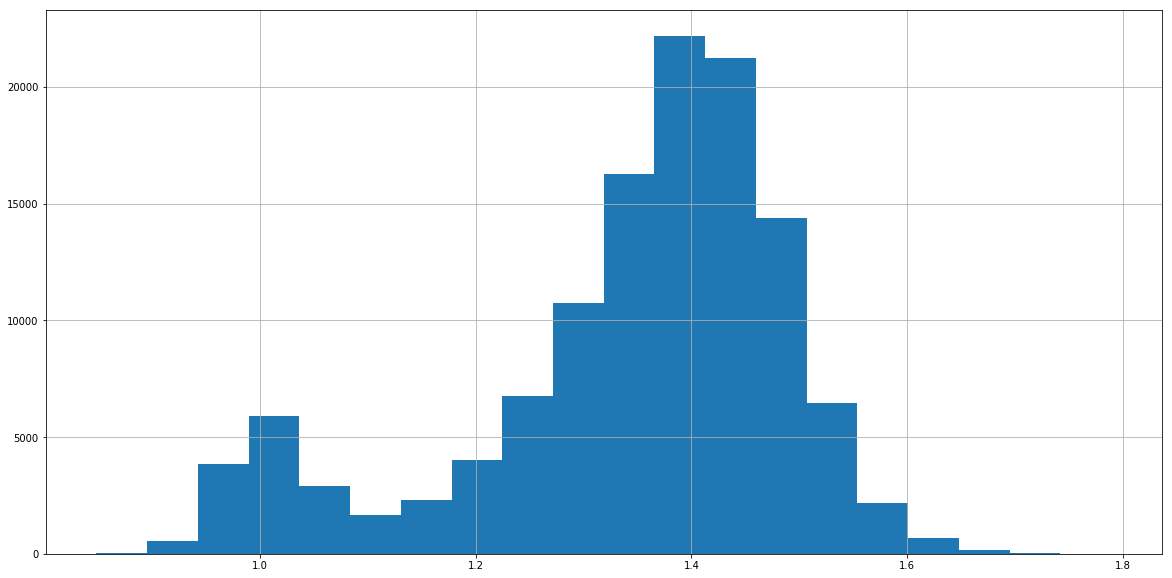

In [18]:
plt.figure(figsize=(20, 10))
plt.hist(df.kf, bins=20)
plt.title('K Factor Distribution')
plt.grid()
plt.show()

In [ ]:
df[df.k_factor > 2.5].shape[0] / df.shape[0]

In [ ]:
plt.scatter(df.estimated_weight_g, df.k_factor)
plt.show()

In [ ]:
weights = np.arange(500, 9000, 500)
mean_kfs = []
for idx in range(len(weights) - 1):
    lo, hi = weights[idx], weights[idx + 1]
    mask = (df.estimated_weight_g > lo) & (df.estimated_weight_g < hi)
    mean_kf = df[mask].k_factor.mean()
    mean_kfs.append(mean_kf)
    

In [ ]:
plt.figure(figsize=(10, 5))
x_pos = np.arange(len(weights[:-1]))
plt.bar(x_pos, mean_kfs, align='edge', width=0.9)
plt.xticks(x_pos, weights[:-1])
plt.title('K-Factor vs. Weight')
plt.xlabel('Predicted weight (g)')
plt.ylabel('Predicted K-factor')
plt.grid()
plt.show()

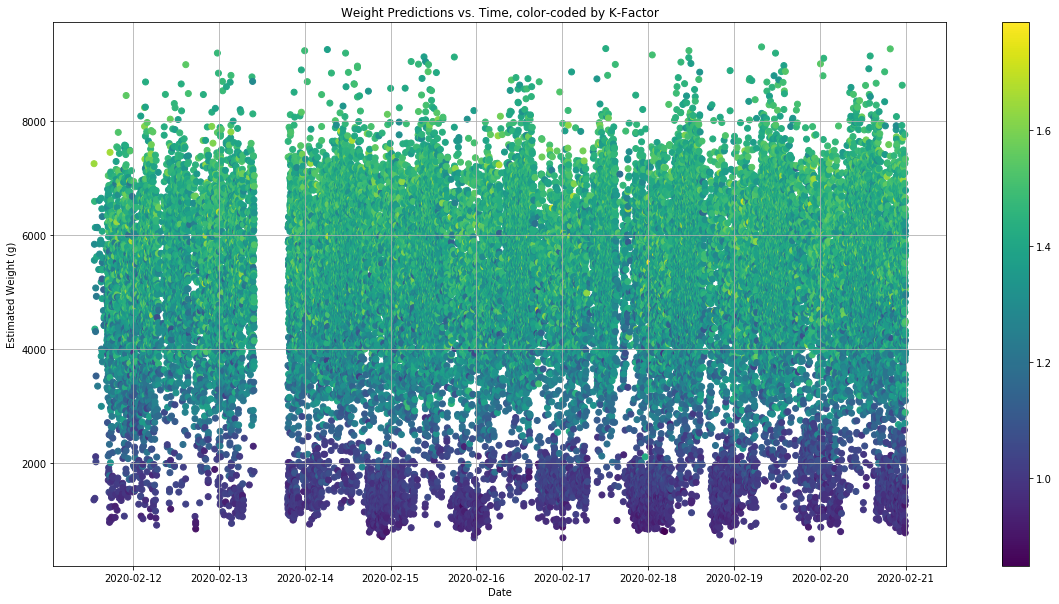

In [21]:
tdf = df[df.kf < np.percentile(df.kf, 100)].copy(deep=True)

plt.figure(figsize=(20, 10))
start_date, end_date = '2020-02-10', '2020-02-20'
plt.scatter(tdf[start_date:end_date].index, 
            tdf[start_date:end_date].estimated_weight_g,
            c=tdf[start_date:end_date].kf, cmap='viridis')
plt.colorbar()
plt.grid()
plt.xlabel('Date')
plt.ylabel('Estimated Weight (g)')
plt.title('Weight Predictions vs. Time, color-coded by K-Factor')
plt.show()